<a href="https://colab.research.google.com/github/LuisFilipeAraujo/CNN_PDI_DogsCats/blob/main/Luis_CatsDogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
'''import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))'''

In [2]:
import numpy as np
import sys
import tensorflow as tf
import os
import sys
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator


%matplotlib inline
import matplotlib.image as img
import matplotlib.pyplot as plt

In [3]:
seed = 0
np.random.seed(seed)
tf.random.set_seed(3)

In [4]:
#install kaggle
!pip install -q kaggle

In [5]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"luisfilipearaujo","key":"1b06e637a6eb985696b41a81b68f6cde"}'}

In [6]:
#criar uma pasta kaggle
! mkdir ~/.kaggle

In [7]:
#copiar o kaggle.json na pasta criada
! cp kaggle.json ~/.kaggle/

In [8]:
#dando permissão para o json "atuar"
! chmod 600 ~/.kaggle/kaggle.json

In [9]:
#O comando da API do dataset requesitado se encontra no aba "Data" do dataset em questão
!kaggle competitions download -c dogs-vs-cats

 98% 797M/812M [00:04<00:00, 202MB/s]
100% 812M/812M [00:04<00:00, 191MB/s]


In [10]:
#Extrair os arquivos agora
!unzip dogs-vs-cats.zip

Archive:  dogs-vs-cats.zip
  inflating: sampleSubmission.csv    
  inflating: test1.zip               
  inflating: train.zip               


In [11]:
!unzip train.zip

A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: train/dog.5499.jpg      
  inflating: train/dog.55.jpg        
  inflating: train/dog.550.jpg       
  inflating: train/dog.5500.jpg      
  inflating: train/dog.5501.jpg      
  inflating: train/dog.5502.jpg      
  inflating: train/dog.5503.jpg      
  inflating: train/dog.5504.jpg      
  inflating: train/dog.5505.jpg      
  inflating: train/dog.5506.jpg      
  inflating: train/dog.5507.jpg      
  inflating: train/dog.5508.jpg      
  inflating: train/dog.5509.jpg      
  inflating: train/dog.551.jpg       
  inflating: train/dog.5510.jpg      
  inflating: train/dog.5511.jpg      
  inflating: train/dog.5512.jpg      
  inflating: train/dog.5513.jpg      
  inflating: train/dog.5514.jpg      
  inflating: train/dog.5515.jpg      
  inflating: train/dog.5516.jpg      
  inflating: train/dog.5517.jpg      
  inflating: train/dog.5518.jpg      
  inflating: train/dog.5519.jpg      
  inflating: train/dog.552.jp

In [12]:
IMAGE_FOLDER_PATH = "train/"
FILE_NAMES = os.listdir(IMAGE_FOLDER_PATH)
WIDTH = 150
HEIGHT = 150

In [13]:
import cv2
import numpy as np
import imutils 
from matplotlib import pyplot as plt
from google.colab import files
from google.colab.patches import cv2_imshow
import matplotlib.image as mpimg
from matplotlib.image import imread
%matplotlib inline

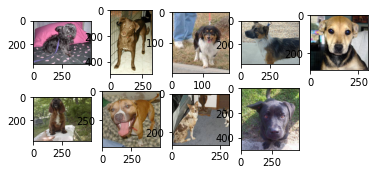

In [14]:
# definir localização do dataset
folder = "train/"
# plotando primeiras imagens
for i in range(9):
  # definir subplot
  plt.subplot(350 + 1 + i)
  # definir "filename"
  filename = folder + 'dog.' + str(i) + '.jpg'
  # carregar pixel da imagem 
  image = imread(filename)

  plt.imshow(image)

plt.show()

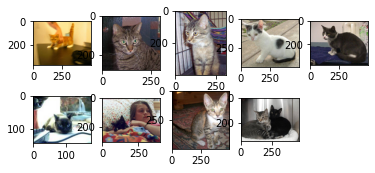

In [15]:
# definir localização do dataset
folder = "train/"
# plotando primeiras imagens
for i in range(9):
  # definir subplot
  plt.subplot(350 + 1 + i)
  # definir "filename"
  filename = folder + 'cat.' + str(i) + '.jpg'
  # carregar pixel da imagem 
  image = imread(filename)

  plt.imshow(image)

plt.show()

In [16]:
FILE_NAMES[0:5]

['cat.6.jpg', 'dog.12403.jpg', 'dog.3494.jpg', 'dog.7799.jpg', 'dog.12131.jpg']

In [17]:
labels = []
for i in os.listdir(IMAGE_FOLDER_PATH):
    labels+=[i]

In [18]:
# Lista vazia
targets = list()
full_paths = list()
train_cats_dir = list()
train_dogs_dir = list()

# encontrando target dos 'files'
for file_name in FILE_NAMES:
    target = file_name.split(".")[0] # nome do target
    full_path = os.path.join(IMAGE_FOLDER_PATH, file_name)
    
    if(target == "dog"):
        train_dogs_dir.append(full_path)
    if(target == "cat"):
        train_cats_dir.append(full_path)
    
    full_paths.append(full_path)
    targets.append(target)

dataset = pd.DataFrame() # fazer dataframe
dataset['image_path'] = full_paths # file path
dataset['target'] = targets # file's target

In [19]:
dataset.head(10)

,image_path,target
0,train/cat.6.jpg,cat
1,train/dog.12403.jpg,dog
2,train/dog.3494.jpg,dog
3,train/dog.7799.jpg,dog
4,train/dog.12131.jpg,dog
5,train/dog.10215.jpg,dog
6,train/cat.9884.jpg,cat
7,train/cat.1079.jpg,cat
8,train/cat.11684.jpg,cat
9,train/dog.1976.jpg,dog


In [20]:
print("total data counts:", dataset['target'].count())
counts = dataset['target'].value_counts()
print(counts)

total data counts: 25000
cat    12500
dog    12500
Name: target, dtype: int64


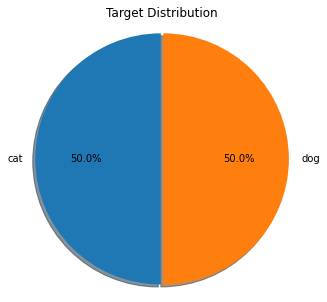

In [21]:
label_count=dataset['target'].value_counts()
explode = (0.01,0.01)  

fig1, ax1 = plt.subplots(figsize=(5,5))
ax1.pie(label_count.values, explode=explode, labels=label_count.index, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal') 
plt.title('Target Distribution')
plt.show()

DIVIDINDO CONTEÚDO

In [22]:
dataset_train, dataset_test = train_test_split(dataset, test_size=0.2, random_state=seed)

In [23]:
class_id_distributionTrain = dataset_train['target'].value_counts()
class_id_distributionTrain.head(10)

cat    10072
dog     9928
Name: target, dtype: int64

In [24]:
class_id_distributionTest = dataset_test['target'].value_counts()
class_id_distributionTest.head(10)

dog    2572
cat    2428
Name: target, dtype: int64

**Image DataGenerator**

In [25]:
train_datagen=ImageDataGenerator(
rotation_range=15,
rescale=1./255,
shear_range=0.1,
zoom_range=0.2,
horizontal_flip=True,
width_shift_range=0.1,
height_shift_range=0.1)

train_datagenerator=train_datagen.flow_from_dataframe(dataframe=dataset_train,
                                                     x_col="image_path",
                                                     y_col="target",
                                                     target_size=(WIDTH, HEIGHT),
                                                     class_mode="binary",
                                                     batch_size=150)

Found 20000 validated image filenames belonging to 2 classes.


In [26]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_datagenerator=test_datagen.flow_from_dataframe(dataframe=dataset_test,
                                                   x_col="image_path",
                                                   y_col="target",
                                                   target_size=(WIDTH, HEIGHT),
                                                   class_mode="binary",
                                                   batch_size=150)

Found 5000 validated image filenames belonging to 2 classes.


**CNN**

In [27]:
# implementando o modelo da camada
model = Sequential()  
model.add(Conv2D(32, kernel_size=(3,3), input_shape=(WIDTH, HEIGHT, 3), activation='relu'))
model.add(Conv2D(64, kernel_size=(3,3), activation = 'relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

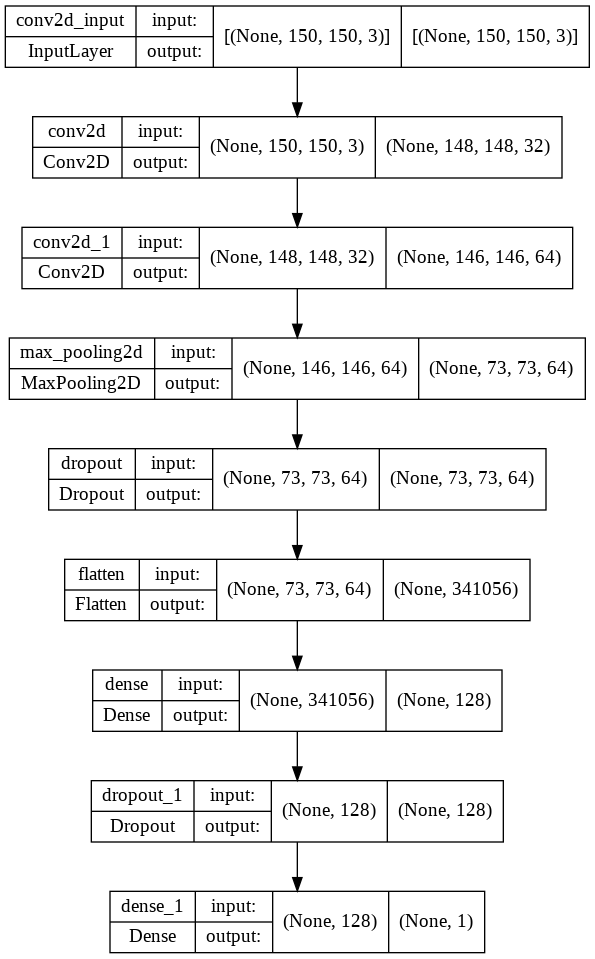

In [28]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model, to_file='convnet.png', show_shapes=True,show_layer_names=True)
Image(filename='convnet.png')

**binary cross-entropy**

In [29]:
model.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 146, 146, 64)      18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 73, 73, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 73, 73, 64)        0         
                                                                 
 flatten (Flatten)           (None, 341056)            0         
                                                                 
 dense (Dense)               (None, 128)               43655296  
                                                        

**TREINAR**

In [ ]:
'''History=model.fit(train_datagenerator,
                       epochs=15,
                       validation_data=test_datagenerator,
                       validation_steps=dataset_test.shape[0]/150,
                       steps_per_epoch=dataset_train.shape[0]/150)'''

In [32]:
History=model.fit(train_datagenerator,
                       epochs=6,
                       validation_data=test_datagenerator,
                       validation_steps=dataset_test.shape[0]/150,
                       steps_per_epoch=dataset_train.shape[0]/150)

Epoch 1/6
133/133 [==============================] - 1914s 14s/step - loss: 0.6567 - accuracy: 0.6144 - val_loss: 0.6079 - val_accuracy: 0.6590
Epoch 2/6
133/133 [==============================] - 1888s 14s/step - loss: 0.6180 - accuracy: 0.6594 - val_loss: 0.5489 - val_accuracy: 0.7084
Epoch 3/6
133/133 [==============================] - 1997s 15s/step - loss: 0.5870 - accuracy: 0.6906 - val_loss: 0.5181 - val_accuracy: 0.7322
Epoch 4/6
133/133 [==============================] - 1890s 14s/step - loss: 0.5612 - accuracy: 0.7118 - val_loss: 0.4964 - val_accuracy: 0.7538
Epoch 5/6
133/133 [==============================] - 1933s 14s/step - loss: 0.5420 - accuracy: 0.7335 - val_loss: 0.4904 - val_accuracy: 0.7516
Epoch 6/6
133/133 [==============================] - 2044s 15s/step - loss: 0.5303 - accuracy: 0.7413 - val_loss: 0.4909 - val_accuracy: 0.7562


Validação dos dados

Text(0.5, 1.0, 'Perda de treinamento e validação por epoch ')

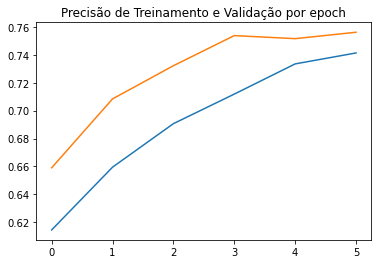

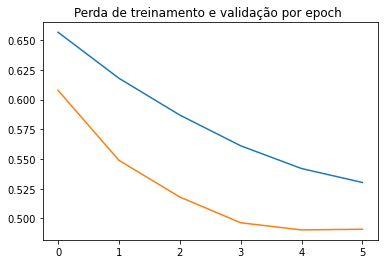

In [36]:
#Precisão do treinamento será em azul e precisão de validação em laranja
acc = History.history['accuracy']
val_acc = History.history['val_accuracy']


loss = History.history['loss']
val_loss = History.history['val_loss']

# Pegando numero de epochs
epochs = range(len(acc))


plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Precisão de Treinamento e Validação por epoch')

plt.figure()


plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Perda de treinamento e validação por epoch ')

**Predizendo Resultados**

In [38]:
test_loss, test_acc = model.evaluate(test_datagenerator, steps=len(test_datagenerator), verbose=1)
print('Loss: %.3f' % (test_loss * 100.0))
print('Accuracy: %.3f' % (test_acc * 100.0))

34/34 [==============================] - 116s 3s/step - loss: 0.4909 - accuracy: 0.7562
Loss: 49.094
Accuracy: 75.620


.